### **Transfer Learning for Image Classification**

In [60]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support

### **(b)Data Exploration and Pre-processing**

In [62]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
NUM_CLASSES = 9  

In [63]:
data_dir = Path("RealWaste")  
all_classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])

train_dir = Path("RealWaste_train")
test_dir  = Path("RealWaste_test")
for d in (train_dir, test_dir):
    d.mkdir(exist_ok=True)

In [64]:
for cls in all_classes:
    cls_path = data_dir/cls
    images = sorted(cls_path.iterdir())
    split = int(0.8 * len(images))
    for img in images[:split]:
        dest = train_dir/cls
        dest.mkdir(exist_ok=True)
        (dest/img.name).write_bytes(img.read_bytes())
    for img in images[split:]:
        dest = test_dir/cls
        dest.mkdir(exist_ok=True)
        (dest/img.name).write_bytes(img.read_bytes())

In [65]:
train_ds = image_dataset_from_directory(
    train_dir, labels="inferred", label_mode="categorical",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE,
    shuffle=True, seed=SEED, validation_split=0.2, subset="training"
)
val_ds = image_dataset_from_directory(
    train_dir, labels="inferred", label_mode="categorical",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE,
    shuffle=True, seed=SEED, validation_split=0.2, subset="validation"
)
test_ds = image_dataset_from_directory(
    test_dir, labels="inferred", label_mode="categorical",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE,
    shuffle=False
)

Found 3798 files belonging to 9 classes.
Using 3039 files for training.
Found 3798 files belonging to 9 classes.
Using 759 files for validation.
Found 954 files belonging to 9 classes.


In [ ]:
normalization_layer = layers.Rescaling(1./255)
augment_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
])
def preprocess(ds, augment=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (augment_layers(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

train_ds = preprocess(train_ds, augment=True)
val_ds   = preprocess(val_ds)
test_ds  = preprocess(test_ds)

### **(c)Transfer Learning**

In [68]:
def build_model(base_model_fn, name):
    base = base_model_fn(
        include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(
        128, activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model(inputs, outputs, name=name)
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [69]:
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16

models_dict = {
    "ResNet50"      : build_model(ResNet50,      "ResNet50_finetune"),
    "ResNet101"     : build_model(ResNet101,     "ResNet101_finetune"),
    "EfficientNetB0": build_model(EfficientNetB0,"EffNetB0_finetune"),
    "VGG16"         : build_model(VGG16,         "VGG16_finetune"),
}
histories = {}

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

class EarlyStoppingMinEpoch(EarlyStopping):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__(**kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.min_epochs - 1:
            return
        super().on_epoch_end(epoch, logs)

In [71]:
for name, model in models_dict.items():
    print(f"\n=== Training {name} ===")
    cb = EarlyStoppingMinEpoch(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        min_epochs=50            
    )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[cb],
        verbose=2
    )
    histories[name] = history


=== Training ResNet50 ===
Epoch 1/100
380/380 - 106s - 279ms/step - accuracy: 0.3103 - loss: 1.9453 - val_accuracy: 0.2846 - val_loss: 1.9139
Epoch 2/100
380/380 - 145s - 380ms/step - accuracy: 0.4084 - loss: 1.6756 - val_accuracy: 0.3636 - val_loss: 1.9528
Epoch 3/100
380/380 - 149s - 392ms/step - accuracy: 0.4603 - loss: 1.5542 - val_accuracy: 0.4018 - val_loss: 1.9372
Epoch 4/100
380/380 - 153s - 403ms/step - accuracy: 0.4873 - loss: 1.4594 - val_accuracy: 0.3821 - val_loss: 2.1147
Epoch 5/100
380/380 - 155s - 409ms/step - accuracy: 0.5090 - loss: 1.3837 - val_accuracy: 0.3768 - val_loss: 2.1222
Epoch 6/100
380/380 - 155s - 408ms/step - accuracy: 0.5439 - loss: 1.3055 - val_accuracy: 0.3953 - val_loss: 2.0988
Epoch 7/100
380/380 - 157s - 413ms/step - accuracy: 0.5663 - loss: 1.2459 - val_accuracy: 0.3860 - val_loss: 2.2054
Epoch 8/100
380/380 - 161s - 424ms/step - accuracy: 0.5989 - loss: 1.1824 - val_accuracy: 0.3874 - val_loss: 2.2541
Epoch 9/100
380/380 - 488s - 1s/step - accura

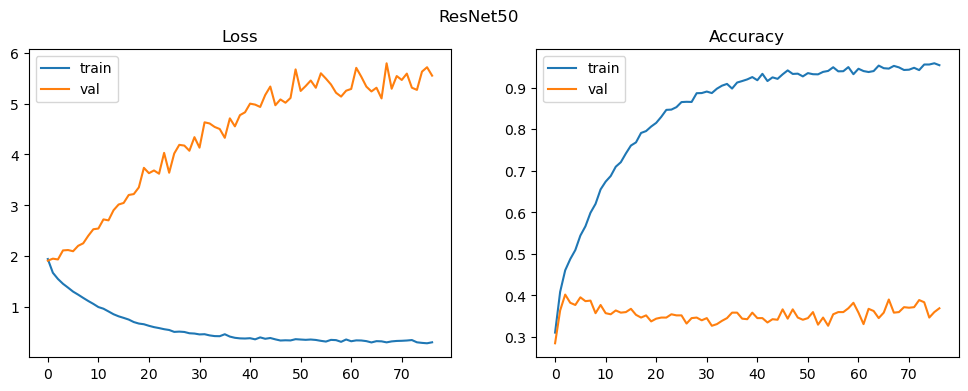

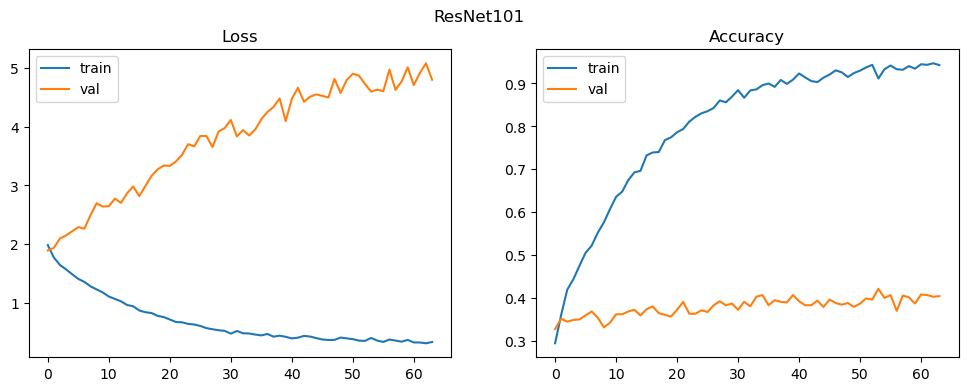

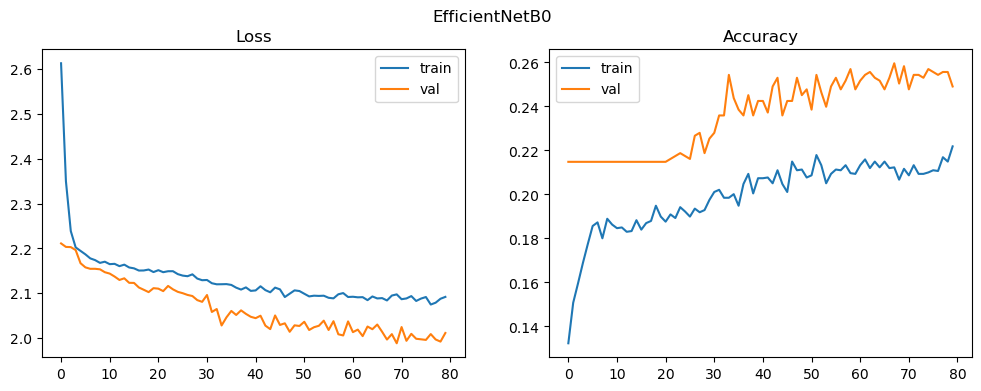

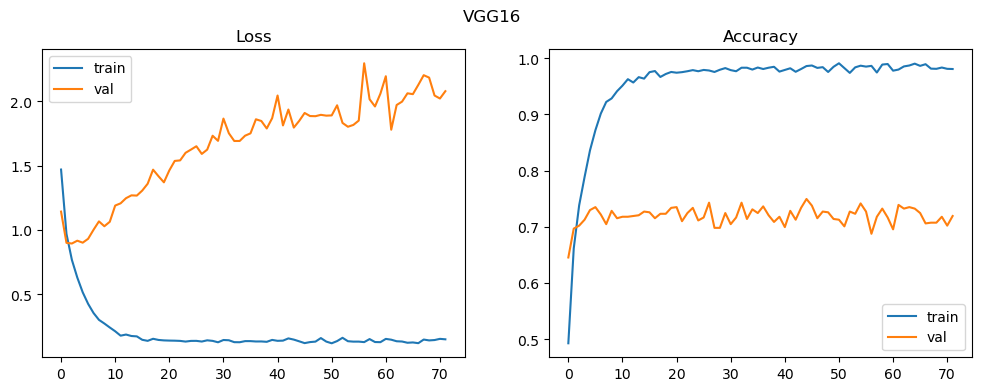

In [72]:
for name, history in histories.items():
    plt.figure(figsize=(12,4))
    plt.suptitle(name)
   
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Loss"); plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy"); plt.legend()
    plt.show()

In [74]:
for name, model in models_dict.items():
    print(f"\n--- {name} ---")
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_true_lbl = np.argmax(y_true, axis=1)
    y_pred_lbl = np.argmax(y_pred, axis=1)

    print(classification_report(
        y_true_lbl, y_pred_lbl, target_names=all_classes, digits=4, zero_division=0
    ))

    try:
        auc = roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr")
        print(f"Macro‑AUC: {auc:.4f}")
    except Exception:
        pass


--- ResNet50 ---
120/120 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step
                       precision    recall  f1-score   support

          1-Cardboard     0.4898    0.2581    0.3380        93
      2-Food Organics     0.6923    0.4337    0.5333        83
              3-Glass     0.2742    0.2024    0.2329        84
              4-Metal     0.3598    0.4873    0.4140       158
5-Miscellaneous Trash     0.2400    0.2424    0.2412        99
              6-Paper     0.3140    0.5400    0.3971       100
            7-Plastic     0.3178    0.1838    0.2329       185
      8-Textile Trash     0.1379    0.0625    0.0860        64
         9-Vegetation     0.3964    0.7614    0.5214        88

             accuracy                         0.3532       954
            macro avg     0.3580    0.3524    0.3330       954
         weighted avg     0.3570    0.3532    0.3341       954

Macro‑AUC: 0.7254

--- ResNet101 ---
120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 403ms/step
                       precision   

2025-05-12 20:33:15.801591: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step
                       precision    recall  f1-score   support

          1-Cardboard     0.0000    0.0000    0.0000        93
      2-Food Organics     0.0000    0.0000    0.0000        83
              3-Glass     0.0000    0.0000    0.0000        84
              4-Metal     0.0435    0.0063    0.0110       158
5-Miscellaneous Trash     0.0000    0.0000    0.0000        99
              6-Paper     0.0000    0.0000    0.0000       100
            7-Plastic     0.2164    1.0000    0.3558       185
      8-Textile Trash     0.0000    0.0000    0.0000        64
         9-Vegetation     0.5789    0.5000    0.5366        88

             accuracy                         0.2411       954
            macro avg     0.0932    0.1674    0.1004       954
         weighted avg     0.1026    0.2411    0.1203       954

Macro‑AUC: 0.6225

--- VGG16 ---
120/120 ━━━━━━━━━━━━━━━━━━━━ 84s 697ms/step
                       precision    recall  f1-score   supp

### **References**

Keras Applications (ResNet, EfficientNet, VGG): https://keras.io/api/applications/</br>

Transfer Learning overview: https://builtin.com/data-science/transfer-learning</br>